# Лабораторная работа №5

## Применение сверточных нейронных сетей (бинарная классификация)

Набор данных _DogsVsCats_, который состоит из изображений различной размерности, содержащих фотографии собак и кошек.

Обучающая выборка включает в себя 25 тыс. изображений (12,5 тыс. кошек: _cat.0.jpg_, ..., _cat.12499.jpg_ и 12,5 тыс. собак: _dog.0.jpg_, …, _dog.12499.jpg_), а контрольная выборка содержит 12,5 тыс. неразмеченных изображений.

Скачать данные, а также проверить качество классификатора на тестовой выборке можно на сайте _Kaggle_: https://www.kaggle.com/c/dogs-vs-cats/data

### Задание 1

Загрузите данные. Разделите исходный набор данных на обучающую, валидационную и контрольную выборки.

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
BASE_DIR = '/content/drive/My Drive/Colab Files/mo-2/dogs-vs-cats'

import sys

sys.path.append(BASE_DIR)

import os

In [0]:
TRAIN_ARCHIVE_NAME = 'train.zip'
TEST_ARCHIVE_NAME = 'test1.zip'

LOCAL_DIR_NAME = 'dogs-vs-cats'

In [0]:
from zipfile import ZipFile

with ZipFile(os.path.join(BASE_DIR, TRAIN_ARCHIVE_NAME), 'r') as zip_:
    zip_.extractall(path = os.path.join(LOCAL_DIR_NAME, 'train'))

with ZipFile(os.path.join(BASE_DIR, TEST_ARCHIVE_NAME), 'r') as zip_:
    zip_.extractall(path = os.path.join(LOCAL_DIR_NAME, 'test-1'))

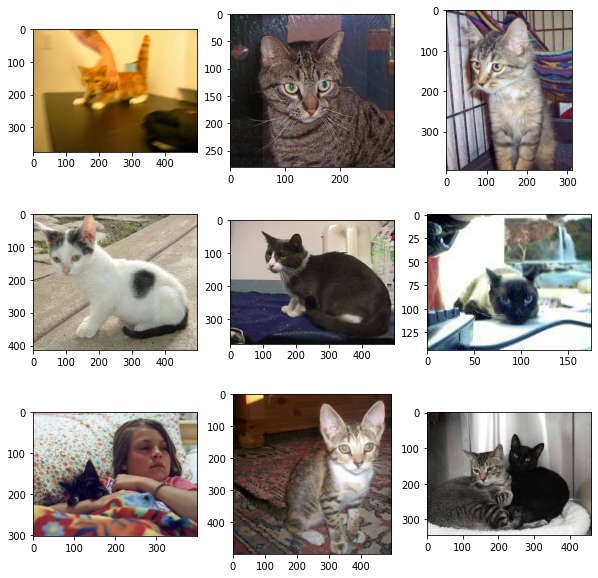

In [5]:
from matplotlib import pyplot
from matplotlib.image import imread

pyplot.rcParams["figure.figsize"] = (10, 10)

dir_ = 'dogs-vs-cats/train/train'

for i in range(9):

    pyplot.subplot(330 + 1 + i)

    image_ = imread('{}/cat.{}.jpg'.format(dir_, i))

    pyplot.imshow(image_)
 
pyplot.show()

Изображения необходимо прирвести к одному размеру.

In [0]:
NEW_IMAGE_WIDTH = 100

In [7]:
from os import listdir
from os.path import join
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

def dir_to_dataset(_dir_path):
	
	photos_, labels_ = [], []

	for file_ in listdir(_dir_path):

		if file_.startswith('cat'):
			label_ = 1.0
		else:
			label_ = 0.0

		photo_ = load_img(join(_dir_path, file_), target_size = (NEW_IMAGE_WIDTH, NEW_IMAGE_WIDTH))

		photo_ = img_to_array(photo_)

		photos_.append(photo_)
		labels_.append(label_)
  
	photos_norm_ = tf.keras.utils.normalize(photos_, axis = 1)

	return asarray(photos_norm_), asarray(labels_)

Using TensorFlow backend.


In [8]:
! pip install tensorflow-gpu --pre --quiet

! pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 2.2.0rc3
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, opt-einsum, numpy, scipy, wheel, protobuf, google-pasta, astunparse, wrapt, termcolor, h5py, tensorboard, gast, tensorflow-estimator, absl-py, keras-preprocessing, grpcio
Required-by: 


In [0]:
import tensorflow as tf

In [0]:
import numpy as np

In [0]:
X_all, y_all = dir_to_dataset('dogs-vs-cats/train/train')

In [0]:
TEST_LEN_HALF = 1000

In [13]:
test_interval = np.r_[0:TEST_LEN_HALF, -TEST_LEN_HALF:-0]

X, y = X_all[TEST_LEN_HALF:-TEST_LEN_HALF], y_all[TEST_LEN_HALF:-TEST_LEN_HALF]
X_test, y_test = X_all[test_interval], y_all[test_interval]

print(X.shape, y.shape)
print(X_test.shape, y_test.shape)

(23000, 100, 100, 3) (23000,)
(2000, 100, 100, 3) (2000,)


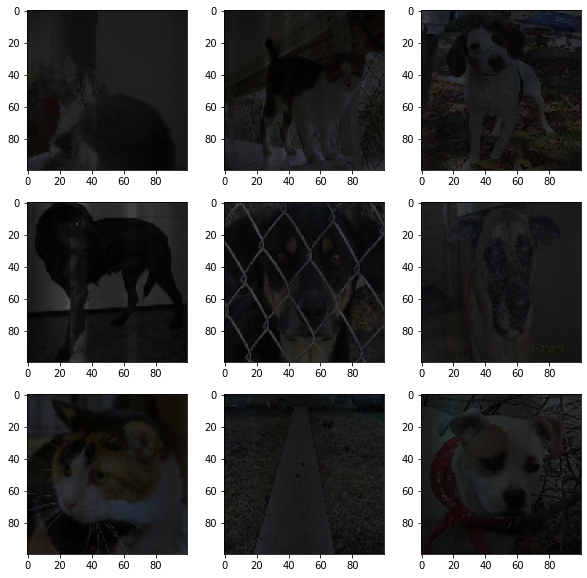

In [14]:
for i in range(9):

    pyplot.subplot(330 + 1 + i)

    pyplot.imshow(X[i])
 
pyplot.show()

Выделение валидационной выборки произойдёт автоматически по параметру `validation_split` метода `model.fit()`.

### Задание 2

Реализуйте глубокую нейронную сеть с как минимум тремя сверточными слоями. Какое качество классификации получено?

In [0]:
from tensorflow import keras

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = tf.keras.Sequential()

model.add(Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape = (NEW_IMAGE_WIDTH, NEW_IMAGE_WIDTH, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'sgd',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [17]:
model.fit(x = X, y = y, epochs = 20, validation_split = 0.15)

Epoch 1/20
611/611 [==============================] - 5s 7ms/step - loss: 0.6910 - accuracy: 0.5330 - val_loss: 0.6884 - val_accuracy: 0.5693
Epoch 2/20
611/611 [==============================] - 4s 7ms/step - loss: 0.6865 - accuracy: 0.5647 - val_loss: 0.6819 - val_accuracy: 0.6322
Epoch 3/20
611/611 [==============================] - 4s 7ms/step - loss: 0.6805 - accuracy: 0.5809 - val_loss: 0.6717 - val_accuracy: 0.6336
Epoch 4/20
611/611 [==============================] - 4s 7ms/step - loss: 0.6738 - accuracy: 0.5808 - val_loss: 0.6702 - val_accuracy: 0.5719
Epoch 5/20
611/611 [==============================] - 4s 7ms/step - loss: 0.6655 - accuracy: 0.5966 - val_loss: 0.6482 - val_accuracy: 0.6475
Epoch 6/20
611/611 [==============================] - 4s 7ms/step - loss: 0.6527 - accuracy: 0.6171 - val_loss: 0.6380 - val_accuracy: 0.6557
Epoch 7/20
611/611 [==============================] - 4s 7ms/step - loss: 0.6378 - accuracy: 0.6395 - val_loss: 0.6373 - val_accuracy: 0.6383
Epoch 

In [18]:
results = model.evaluate(X_test, y_test)

print('Test loss, test accuracy:', results)

63/63 [==============================] - 0s 4ms/step - loss: 0.4963 - accuracy: 0.7505
Test loss, test accuracy: [0.4963347613811493, 0.7505000233650208]


Результат &mdash; 75% на тестовой выборке.

### Задание 3

Примените дополнение данных (_data augmentation_). Как это повлияло на качество классификатора?

In [0]:
def augment_image(image):

  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_crop_or_pad(image, NEW_IMAGE_WIDTH + 40, NEW_IMAGE_WIDTH + 40)
  image = tf.image.random_crop(image, size = [NEW_IMAGE_WIDTH, NEW_IMAGE_WIDTH, 3])

  return image.numpy()

In [20]:
X_augmented = np.zeros_like(X)

for i, img in enumerate(X):

    X_augmented[i] = augment_image(img)

X_augmented.shape

(23000, 100, 100, 3)

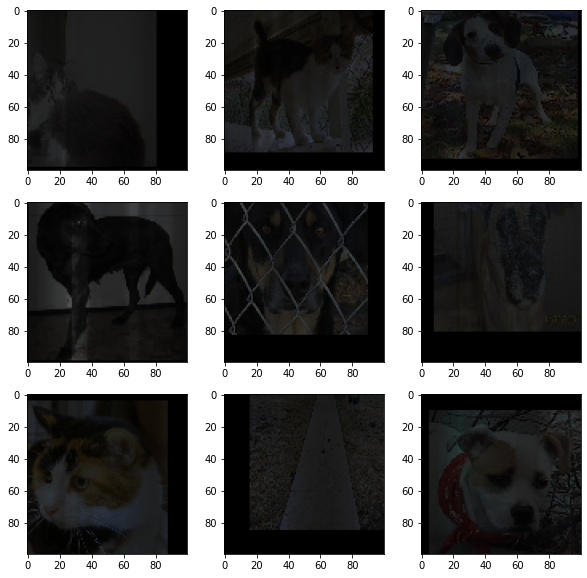

In [21]:
for i in range(9):

    pyplot.subplot(330 + 1 + i)

    pyplot.imshow(X_augmented[i])
 
pyplot.show()

In [0]:
y_augmented = y

In [23]:
model.fit(x = X_augmented, y = y_augmented, epochs = 20, validation_split = 0.15)

Epoch 1/20
611/611 [==============================] - 4s 7ms/step - loss: 0.6068 - accuracy: 0.6690 - val_loss: 0.5740 - val_accuracy: 0.7000
Epoch 2/20
611/611 [==============================] - 4s 7ms/step - loss: 0.5807 - accuracy: 0.6941 - val_loss: 0.5641 - val_accuracy: 0.7110
Epoch 3/20
611/611 [==============================] - 4s 7ms/step - loss: 0.5697 - accuracy: 0.7006 - val_loss: 0.5608 - val_accuracy: 0.7157
Epoch 4/20
611/611 [==============================] - 4s 7ms/step - loss: 0.5559 - accuracy: 0.7105 - val_loss: 0.5525 - val_accuracy: 0.7200
Epoch 5/20
611/611 [==============================] - 4s 7ms/step - loss: 0.5443 - accuracy: 0.7204 - val_loss: 0.5469 - val_accuracy: 0.7212
Epoch 6/20
611/611 [==============================] - 4s 7ms/step - loss: 0.5325 - accuracy: 0.7330 - val_loss: 0.5758 - val_accuracy: 0.6991
Epoch 7/20
611/611 [==============================] - 4s 7ms/step - loss: 0.5196 - accuracy: 0.7426 - val_loss: 0.5517 - val_accuracy: 0.7067
Epoch 

In [24]:
results_2 = model.evaluate(X_test, y_test)

print('Test loss, test accuracy:', results_2)

63/63 [==============================] - 0s 4ms/step - loss: 0.5276 - accuracy: 0.7670
Test loss, test accuracy: [0.5276018381118774, 0.7670000195503235]


После того, как сеть обучилась на тех же данных, к которым был применён data augmentation, точность предсказания на тестовой выборке увеличилась ненамного &mdash; до 76%.

### Задание 4

Поэкспериментируйте с готовыми нейронными сетями (например, _AlexNet_, _VGG16_, _Inception_ и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора?

Какой максимальный результат удалось получить на сайте _Kaggle_? Почему?